# Custom Tutorial 3: Parameter inference

In this tutorial, we demonstrate how to fit your custom model to data. The process is nearly identical to that of the precoded sub-module, so we will principally focus on what's different between the precoded and custom versions here. Refer to Default Tutorial 3 for use details.

The specific model we will use for this example is the urgency gating model with time depenedent drift discussed in PyBEAM's publication, referred to as UGM_flip. This model is also available in PyBEAM's precoded sub-module, with Tutorial 1f on github discussing its use. In this model, the drift rate flips from positive to negative at time t_flip. The model files for this example are on PyBEAM's github under the folder UGM_flip.

As before, import PyBEAM's custom submodule. We additionally import matplotlib for plotting and os to check that our directory is input correctly.


In [1]:
# import PyBEAM's custom submodule
import pybeam.custom as pbc

# also import pyplot to modify figure axes
import matplotlib.pyplot as plt

# import os to check if you have input your model directory correctly
import os


Next, as in Custom Tutorial 2, we need to tell the program where your model is located at. To do this, create a string containing the FULL directory name.


In [2]:
# the directory containing your model goes here
model_dir = ''

# for windows computers, r before the directory is necessary
# model_dir = r''

# check if directory is input properly
os.path.isdir(model_dir)


True

We next call functions_test to make sure that our model is acting as expected.


In [3]:
# dictionary containing model parameters
phi = {'phi[0]' : 0.25, # tnd: non-decision time
       'phi[1]' : 0.5,  # w: relative start point
       'phi[2]' : 1.0,  # mu: drift rate
       'phi[3]' : 3.0,  # l: leakage rate
       'phi[4]' : 2.0,  # k: urgency ratio
       'phi[5]' : 0.5,  # t0: time for first drift rate flip
       'phi[6]' : 1.0,  # sigma: model scale
       'phi[7]' : 1.0}  # b: threshold location
    
# run function to test if model functions are input properly
pbc.functions_test(model_dir = model_dir, # string containing directory name where your model files are
                         phi = phi,       # dictionary of model parameters
                           x = 0.0,       # accumulator state
                           t = 1.0)       # time


[['non_decision_time', 0.25],
 ['relative_start', 0.5],
 ['drift', -3.0],
 ['diffusion', 3.0],
 ['upper_decision_threshold', 1.0],
 ['lower_decision_threshold', -1.0],
 ['contamination_strength', 0.0],
 ['contamination_probability', 0.0],
 ['modify_dt', 1.0]]

Next, we simulate two data sets. These encode two different conditions: a low caution and high caution condition encoded in lower and higher threshold locations, respectively.

To do this, we first set the parameters for each data set. We follow the same process as in Custom Tutorial 2, where we generate a dictionary with keys corresponding to the parameters defined in your model file, and values giving the value of that parameter.


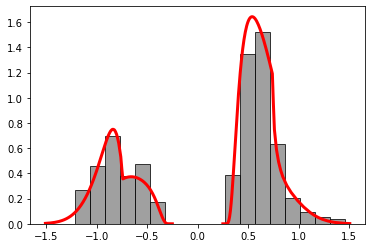

In [4]:
# set parameters for data set 0
phi0 = {'phi[0]' : 0.25,  # tnd: non-decision time
        'phi[1]' : 0.5,   # w: relative start point
        'phi[2]' : 1.0,   # mu: drift rate
        'phi[3]' : 3.0,   # l: leakage rate
        'phi[4]' : 2.0,   # k: urgency ratio
        'phi[5]' : 0.5,   # t_flip: time for the drift rate flip
        'phi[6]' : 1.0,   # sigma: model scale
        'phi[7]' : 1.0}   # b: threshold location

# simulate data for parameter set 0
rt0 = pbc.simulate(model_dir = model_dir,
                      N_sims = 500,
                         phi = phi0)

# plot data set 0
pbc.plot_rt(model_dir = model_dir,
                  phi = phi0,
                   rt = rt0,
               rt_max = 1.5);


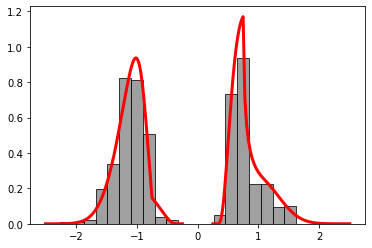

In [5]:
# set parameters for data set 1
phi1 = {'phi[0]' : 0.25,  # tnd: non-decision time
        'phi[1]' : 0.5,   # w: relative start point
        'phi[2]' : 1.0,   # mu: drift rate
        'phi[3]' : 3.0,   # l: leakage rate
        'phi[4]' : 2.0,   # k: urgency ratio
        'phi[5]' : 0.5,   # t_flip: time for the drift rate flip
        'phi[6]' : 1.0,   # sigma: model scale
        'phi[7]' : 1.5}   # b: threshold location

# simulate data for parameter set 1
rt1 = pbc.simulate(model_dir = model_dir,
                      N_sims = 500,
                         phi = phi1)

# plot data set 1
pbc.plot_rt(model_dir = model_dir,
                  phi = phi1,
                   rt = rt1,
               rt_max = 2.5);


Next, we call the parameter inference function. To do this, we follow the same procedure as in Precoded Tutorial 3. First, we define our bank of priors. The key names an be anything, so we give them a name convenient for our situation i.e. the prior for phi[0] is pphi[0], and so on. The values for each key are the priors themselves written in PyMC syntax (made into strings). In this case, we use PyMC's uniform priors, with the syntax:

    Uniform( "prior name" , lower = (lower bound of prior) ,upper = (upper bound of prior) ) 

Other available PyMC priors are located on the PyMC website at the following link:

    https://www.pymc.io/projects/docs/en/stable/api/distributions.html


In [6]:
# define bank of priors
p = {'pphi[0]' : 'Uniform("t_nd", lower = 0.0, upper = 0.75)',   # non-decision time prior
     'pphi[1]' : 'Uniform("w", lower = 0.3, upper = 0.7)',       # relative start point prior
     'pphi[2]' : 'Uniform("mu", lower = -5.0, upper = 5.0)',     # drift rate prior
     'pphi[3]' : 'Uniform("l", lower = 0.0, upper = 10.0)',      # leakage rate prior
     'pphi[4]' : 'Uniform("k", lower = 0.0, upper = 10.0)',      # urgency rate prior
     'pphi[5]' : 'Uniform("t_flip", lower = 0.01, upper = 1.0)', # first drift flip time
     'pphi[6]' : 1.0,                                            # scaling parameter
     'pphi[7]0' : 'Uniform("a0", lower = 0.25, upper = 3.0)',    # decision threshold prior 0
     'pphi[7]1' : 'Uniform("a1", lower = 0.25, upper = 3.0)'}    # decision threshold prior 1


We next define two dictionaries which set which priors are associated with what parameters and which data set for each condition. This dictionary contains keys corresponding to each parameter. For the UGM_flip model we defined, we will have keys of 'phi[0]', 'phi[1]', ... , 'phi[7]', since the model has 8 parameters. The values of these keys indicate which priors from the prior dictionary are associated with each parameter. So, for example, parameter 'phi[0]' has the prior associated with prior key 'pphi[0]'.

In addition to the parameters, a key 'rt' is required. This key contains the data you would like to fit. This data set must be in the same form as that output by the simulate model function. It must have two keys, 'rt_upper' and 'rt_lower'. The values for these keys must be 1D lists/numpy arrays containing the reaction time data for the two choices (crossing the upper and lower decision thresholds, respectively).

This dictionary is then loaded into one last dictionary which will be input into the inference function.


In [7]:
# define condition 0 dictionary
c0 = {'rt' : rt0,
  'phi[0]' : 'pphi[0]', 
  'phi[1]' : 'pphi[1]',  
  'phi[2]' : 'pphi[2]', 
  'phi[3]' : 'pphi[3]',  
  'phi[4]' : 'pphi[4]',  
  'phi[5]' : 'pphi[5]',
  'phi[6]' : 'pphi[6]', 
  'phi[7]' : 'pphi[7]0'}

# define condition 1 dictionary
c1 = {'rt' : rt1,
  'phi[0]' : 'pphi[0]', 
  'phi[1]' : 'pphi[1]',  
  'phi[2]' : 'pphi[2]', 
  'phi[3]' : 'pphi[3]',  
  'phi[4]' : 'pphi[4]',  
  'phi[5]' : 'pphi[5]',
  'phi[6]' : 'pphi[6]', 
  'phi[7]' : 'pphi[7]1'}
 
cond = {0 : c0, 1 : c1}


We now run PyBEAM's parameter inference program, inference. This takes the input data and priors and outputs posteriors for each parameter. It requires inputs of the model directory, the prior dictionary, the conditions dictionary, chains (how many mcmc chains you want), cores (how many cpu cores to run those chains on), and file name (a string containing the file name to save the posteriors to).

This function has a few additional optional inputs that generally are not needed. These include resolution settings and MCMC solvers different than the default. These are disucssed fully in the "precoded_functions" notebook in folder Tutorials on the PyBEAM github.


In [8]:
idata = pbc.inference(model_dir = model_dir, # specify model directory
                         priors = p,         # dictionary of priors
                     conditions = cond,      # conditions dictionary
                        samples = 50000,     # MCMC samples
                         chains = 3,         # MCMC chains 
                          cores = 3,         # CPU cores to run MCMC chains on
                      file_name = 'custom')  # output file name


Multiprocess sampling (3 chains in 3 jobs)
DEMetropolisZ: [t_nd, w, mu, l, k, t_flip, a0, a1]


Sampling 3 chains for 0 tune and 50_000 draw iterations (0 + 150_000 draws total) took 138 seconds.


PyBEAM contains two more useful functions. The first, plot_idata, plots the posteriors output by the program. The second, summary, provides posterior summary statistics. They both accept input of the file name, in addition to a 'burnin' which sets how many of the samples need to be thrown out from the beginning.

Both functions are from the arviz library, so see the arviz/pymc documentation for more information about them.


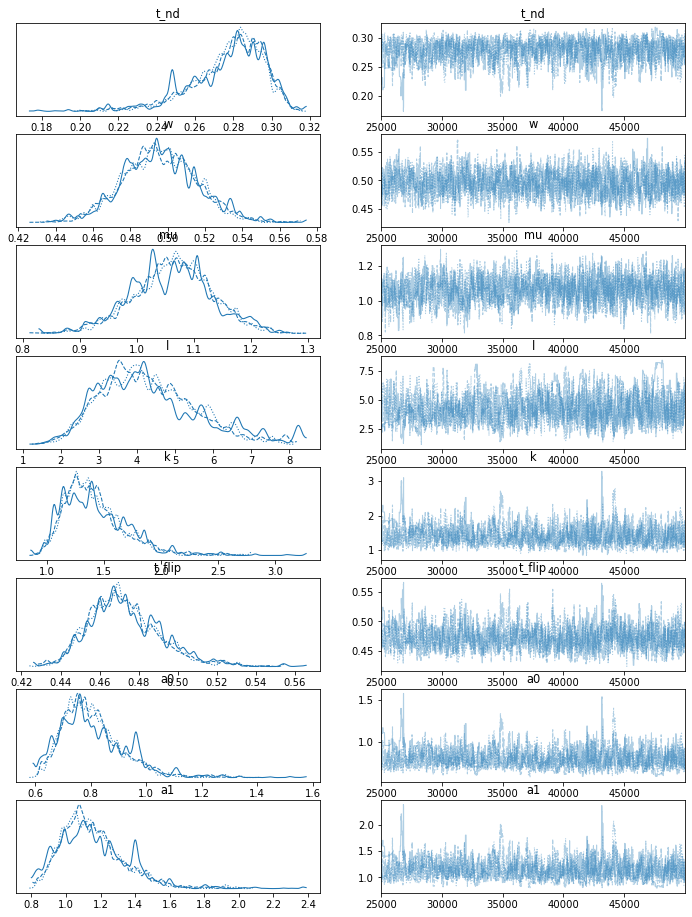

In [9]:
# plot posteriors
pbc.plot_idata(file_name = 'custom', burnin = 25000);


In [10]:
# summary of posteriors
pbc.summary(file_name = 'custom', burnin = 25000)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_nd,0.277,0.019,0.244,0.309,0.001,0.001,456.0,582.0,1.02
w,0.496,0.020,0.460,0.534,0.001,0.001,630.0,1103.0,1.01
mu,1.063,0.069,0.929,1.195,0.003,0.002,562.0,1016.0,1.03
l,4.311,1.282,2.235,6.868,0.135,0.110,161.0,249.0,1.04
k,1.420,0.281,0.970,1.898,0.020,0.014,190.0,549.0,1.03
t_flip,0.473,0.019,0.441,0.508,0.001,0.001,597.0,802.0,1.01
a0,0.806,0.115,0.613,0.998,0.008,0.006,154.0,189.0,1.03
a1,1.157,0.193,0.832,1.481,0.014,0.010,149.0,318.0,1.03
